<a href="https://colab.research.google.com/github/escapingLife/mashinePrograming/blob/master/10%EC%A3%BC%EC%B0%A8/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -----------------------------------------------------------
# 라이브러리 임포트
# -----------------------------------------------------------
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------------------------------------
# 개별 파일 읽기
# -----------------------------------------------------------
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# -----------------------------------------------------------
# 여러 파일을 읽어서 3차원 배열로 합치기
# -----------------------------------------------------------
def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(os.path.join(prefix, name))
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

# -----------------------------------------------------------
# train/test 그룹별 데이터 로드
# -----------------------------------------------------------
def load_dataset_group(group, dataset_path):
    signals_path = os.path.join(dataset_path, group, 'Inertial Signals')
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt',  'body_acc_y_'+group+'.txt',  'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, signals_path)
    y = load_file(os.path.join(dataset_path, group, 'y_'+group+'.txt'))
    return X, y

# -----------------------------------------------------------
# 전체 데이터셋 로드
# -----------------------------------------------------------
def load_dataset(dataset_path):
    trainX, trainy = load_dataset_group('train', dataset_path)
    testX, testy = load_dataset_group('test', dataset_path)

    # 라벨 보정 (1~6 → 0~5)
    trainy = trainy - 1
    testy = testy - 1

    # 원-핫 인코딩
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print(f"trainX: {trainX.shape}, trainy: {trainy.shape}")
    print(f"testX: {testX.shape}, testy: {testy.shape}")
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

# -----------------------------------------------------------
# 실행: 데이터 로드
# -----------------------------------------------------------
dataset_path = r"/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset"
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(dataset_path)

/tmp/ipython-input-1680962307.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1680962307.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1680962307.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1680962307.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=Tr

trainX: (7352, 128, 9), trainy: (7352, 1)
testX: (2947, 128, 9), testy: (2947, 1)


In [2]:
# -----------------------------------------------------------
# train 데이터를 다시 train/validation으로 분리
# -----------------------------------------------------------
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

print("\n데이터 분할 결과:")
print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train_one_hot:", y_train_one_hot.shape, "y_val_one_hot:", y_val_one_hot.shape)


데이터 분할 결과:
X_train: (5881, 128, 9) X_val: (1471, 128, 9)
y_train_one_hot: (5881, 6) y_val_one_hot: (1471, 6)


In [3]:
# -----------------------------------------------------------
# 데이터 스케일링 (StandardScaler)
# -----------------------------------------------------------
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_val_scaled   = scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
testX_scaled   = scaler.transform(testX.reshape(-1, testX.shape[2])).reshape(testX.shape)

In [4]:
# -----------------------------------------------------------
# 입력/출력 차원 설정
# -----------------------------------------------------------
n_timesteps, n_features, n_outputs = X_train_scaled.shape[1], X_train_scaled.shape[2], y_train_one_hot.shape[1]

In [5]:
# -----------------------------------------------------------
# LSTM 모델 정의
# -----------------------------------------------------------
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(n_outputs, activation='softmax')
])

lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # LSTM은 느리게 학습하는 게 좋음
    metrics=['accuracy']
)

lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,550 (861.52 KB)

 Trainable params: 220,038 (859.52 KB)

 Non-trainable params: 512 (2.00 KB)

In [6]:
# -----------------------------------------------------------
# 조기 종료 콜백
# -----------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [7]:
# -----------------------------------------------------------
# 학습
# -----------------------------------------------------------
history = lstm_model.fit(
    X_train_scaled, y_train_one_hot,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_scaled, y_val_one_hot),
    callbacks=[es],
    verbose=1
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.3951 - loss: 1.6288 - val_accuracy: 0.6213 - val_loss: 1.4300
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6639 - loss: 0.8661 - val_accuracy: 0.7750 - val_loss: 1.0032
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7477 - loss: 0.6636 - val_accuracy: 0.8484 - val_loss: 0.6022
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8015 - loss: 0.5234 - val_accuracy: 0.8838 - val_loss: 0.3659
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8473 - loss: 0.4431 - val_accuracy: 0.9171 - val_loss: 0.2497
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8731 - loss: 0.3498 - val_accuracy: 0.9191 - val_loss: 0.1966
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9094 - loss: 0.2692 - val_accuracy: 0.9307 - val_loss: 0.1643
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9282 - loss: 0.2242 - val_accuracy: 0.

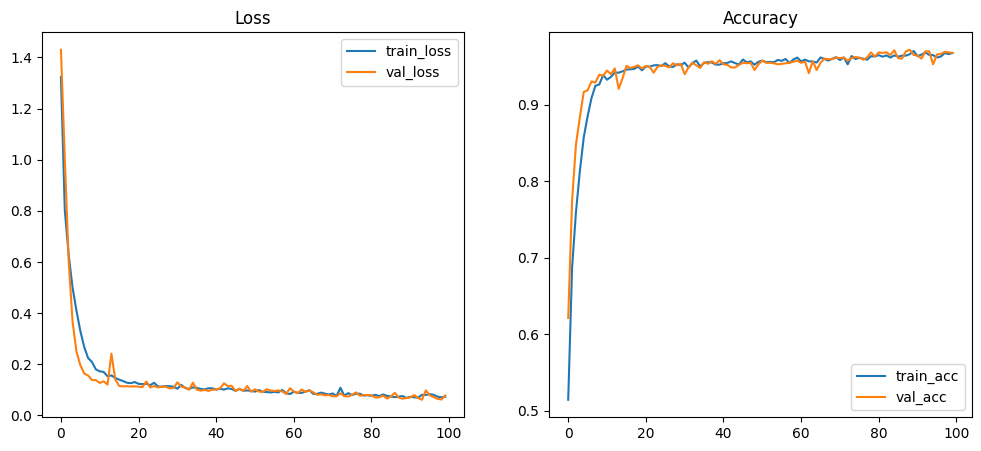

In [11]:
# -----------------------------------------------------------
# 손실 및 정확도 시각화
# -----------------------------------------------------------
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [12]:
# -----------------------------------------------------------
# 테스트 데이터 평가
# -----------------------------------------------------------
pred = lstm_model.predict(testX_scaled)
pred_classes = np.argmax(pred, axis=1)

cm = confusion_matrix(testy, pred_classes)
acc = accuracy_score(testy, pred_classes)

print(f"\nTest Accuracy: {acc * 100:.2f} %")
print(classification_report(testy, pred_classes))

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Test Accuracy: 92.47 %
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       496
           1       0.95      0.97      0.96       471
           2       1.00      1.00      1.00       420
           3       0.77      0.83      0.80       491
           4       0.87      0.78      0.82       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.92      0.92      2947



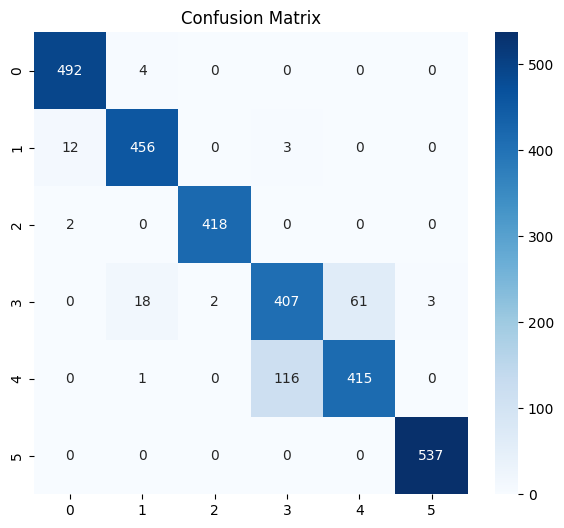

In [13]:
# -----------------------------------------------------------
# 혼동 행렬 시각화
# -----------------------------------------------------------
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()